In [74]:
library(forecast)
library(tseries)
library(lmtest)
library(Hmisc)
library(MLmetrics)

options(repr.plot.width = 15, repr.plot.height = 6)

## Предсказание количества поездок с использованием auto.arima

Загрузим сначала заранее подготовленные данные о количестве поедок, которые начались в данный промежуток времени (частота - 30 минут).

Будем предсказывать количество поездок на неделю вперёд.

In [75]:
train <- read.csv('train_ts.csv')
test <- read.csv('test_ts.csv')

In [76]:
head(train, 3)

,time,count
,<fct>,<int>
1,2016-05-05 18:30:00,15
2,2016-05-05 19:00:00,15
3,2016-05-05 19:30:00,10


In [77]:
tail(test, 3)

,time,count
,<fct>,<int>
334,2016-08-31 22:00:00,4
335,2016-08-31 22:30:00,4
336,2016-08-31 23:30:00,5


Переведём данные в нужный формат.

In [78]:
trainSeries <- ts(train$count)
testSeries <- ts(test$count)

Посмотрим визуально на данные.

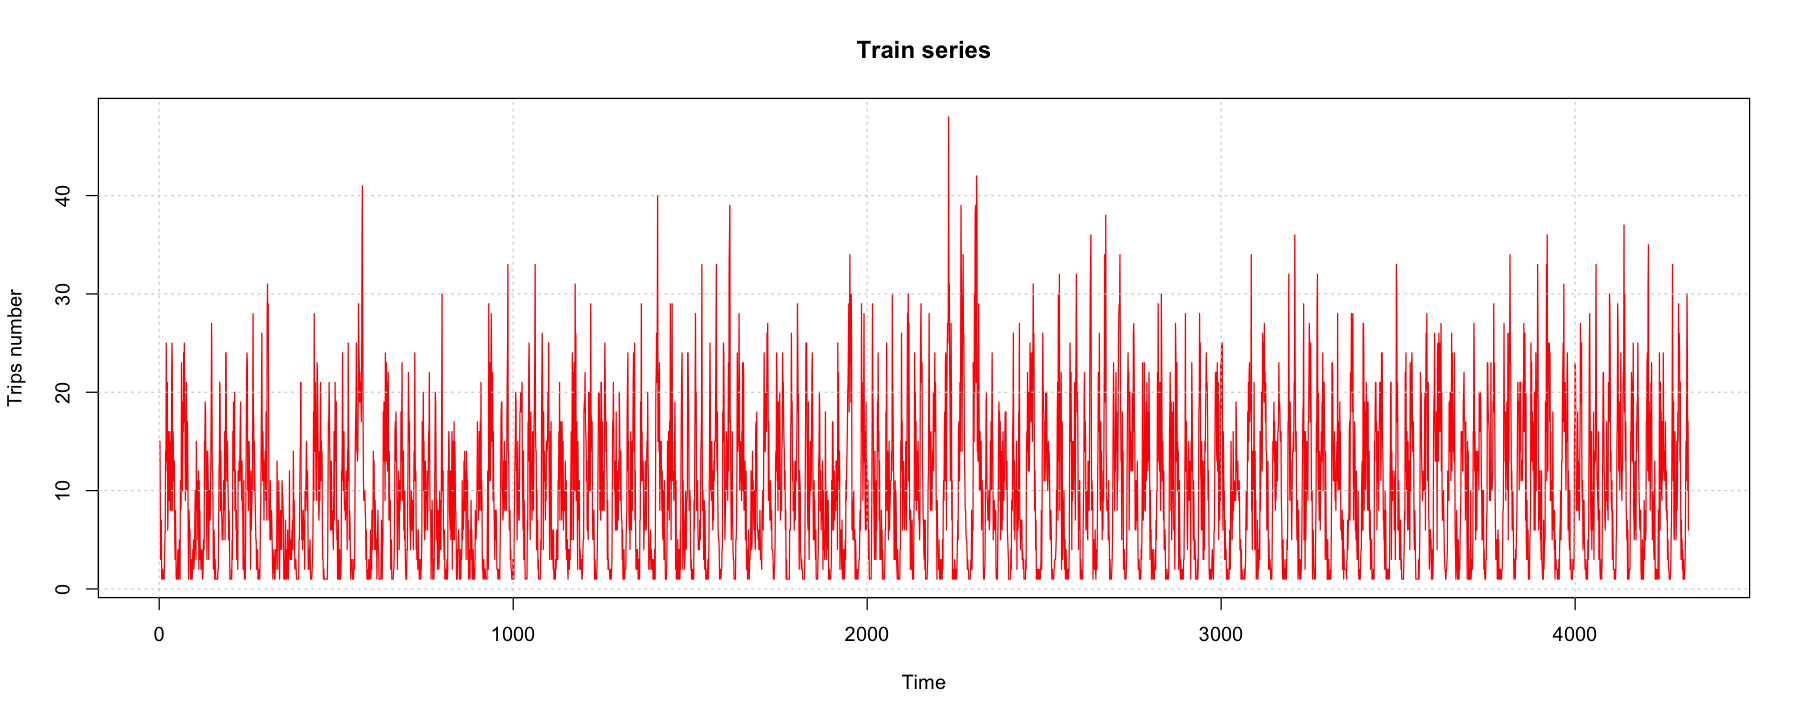

In [79]:
xname <- "Trips number"
plot(trainSeries, type = "l", ylab = xname, col = "red",
     main="Train series",)
grid()

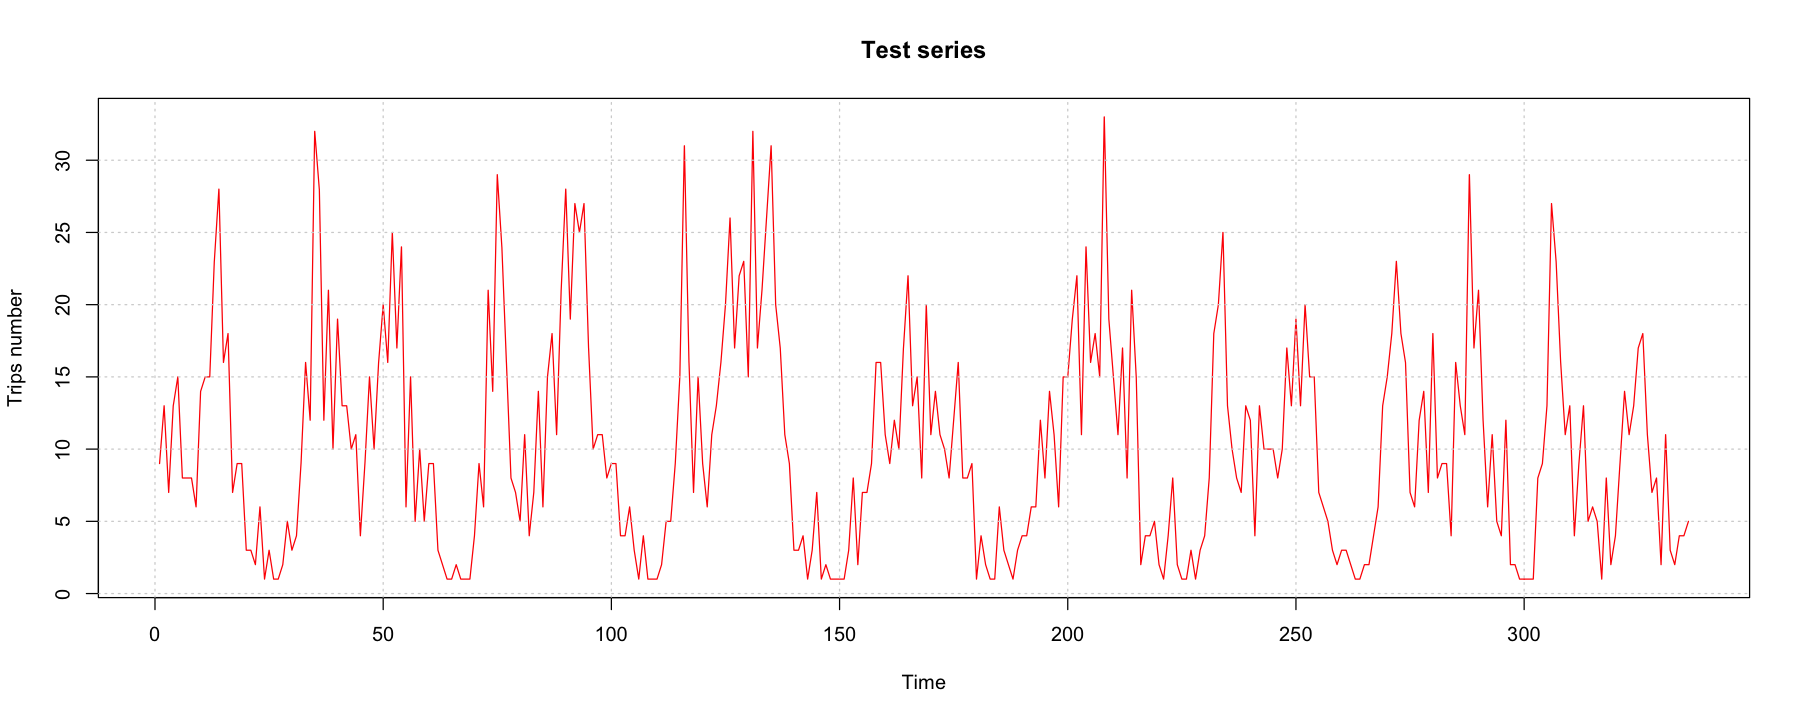

In [80]:
plot(testSeries, type = "l", ylab = xname, col = "red",
     main = "Test series")
grid()

### 1) auto.arima

Обучим модель.

In [83]:
model.auto <- auto.arima(trainSeries)
model.auto

Series: trainSeries 
ARIMA(1,1,1) 

Coefficients:
          ar1      ma1
      -0.1351  -0.2321
s.e.   0.0460   0.0456

sigma^2 estimated as 29.48:  log likelihood=-13434.23
AIC=26874.45   AICc=26874.46   BIC=26893.57

In [84]:
data <- rbind(train, test)
tSeries <- ts(data = data$count)

Предсказания модели.

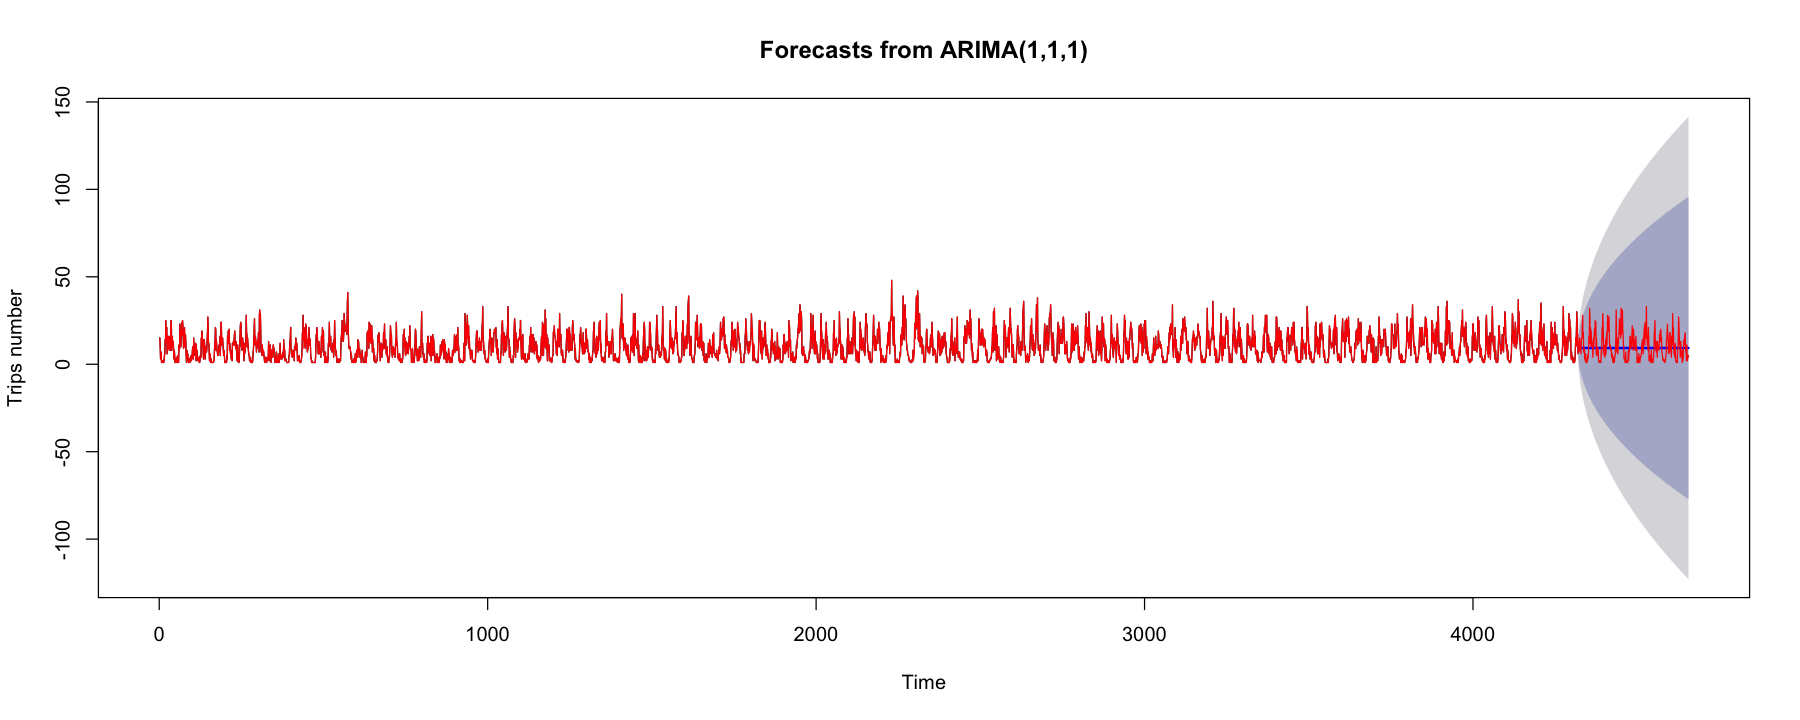

In [85]:
test_size <- nrow(test)
predicted <- forecast(model.auto, h=test_size)

values = data.frame(predicted)$Point.Forecast

plot(predicted, ylab = xname, xlab = "Time")
lines(tSeries, col = "red")

In [71]:
MSE(values, testSeries)

[1] 55.49089

***auto.arima***, как обычно, предсказала всё константой.

### 2) auto.arima + экзогенные факторы

Добавим в модель экзогенные факторы. Например, погодные условия.

(Загрузим уже готовый временной ряд с экзогенными факторами, погдотовленный в ноутбуке с анализом временных рядов)

In [45]:
data_exog <- read.csv('series_exog.csv')
head(series_exog)

,X,time,count,date,Date,Mean_Temperature_F,MeanDew_Point_F,Mean_Humidity
,<int>,<fct>,<int>,<fct>,<fct>,<dbl>,<int>,<int>
1,0,2014-10-13 10:30:00,12,2014-10-13,2014-10-13,62,51,68
2,1,2014-10-13 11:30:00,108,2014-10-13,2014-10-13,62,51,68
3,2,2014-10-13 12:00:00,42,2014-10-13,2014-10-13,62,51,68
4,3,2014-10-13 12:30:00,42,2014-10-13,2014-10-13,62,51,68
5,4,2014-10-13 13:00:00,36,2014-10-13,2014-10-13,62,51,68
6,5,2014-10-13 13:30:00,42,2014-10-13,2014-10-13,62,51,68


Разделим выборку на обучающую и тестовую.

In [46]:
test_size <- 48*7
train_size <- 48*30*3

train_exog <- head(tail(data_exog, test_size + train_size), train_size)
test_exog <- tail(data_exog, test_size)

In [65]:
train_exog_values = train_exog[, c('Mean_Temperature_F', 'MeanDew_Point_F',
                                   'Mean_Humidity')]

test_exog_values = test_exog[, c('Mean_Temperature_F', 'MeanDew_Point_F',
                                   'Mean_Humidity')]

Обучим модель

In [66]:
model_exog <- auto.arima(trainSeries, xreg=data.matrix(train_exog_values))
model_exog

Series: trainSeries 
Regression with ARIMA(3,0,2) errors 

Coefficients:
         ar1      ar2      ar3      ma1     ma2  intercept  Mean_Temperature_F
      1.6772  -0.5846  -0.1264  -1.1644  0.2208     6.0411             -0.0047
s.e.  0.0529   0.0906   0.0396   0.0526  0.0502     3.8473              0.0839
      MeanDew_Point_F  Mean_Humidity
               0.1657        -0.0659
s.e.           0.0892         0.0364

sigma^2 estimated as 26.16:  log likelihood=-13176.85
AIC=26373.7   AICc=26373.75   BIC=26437.41

Предсказания модели.

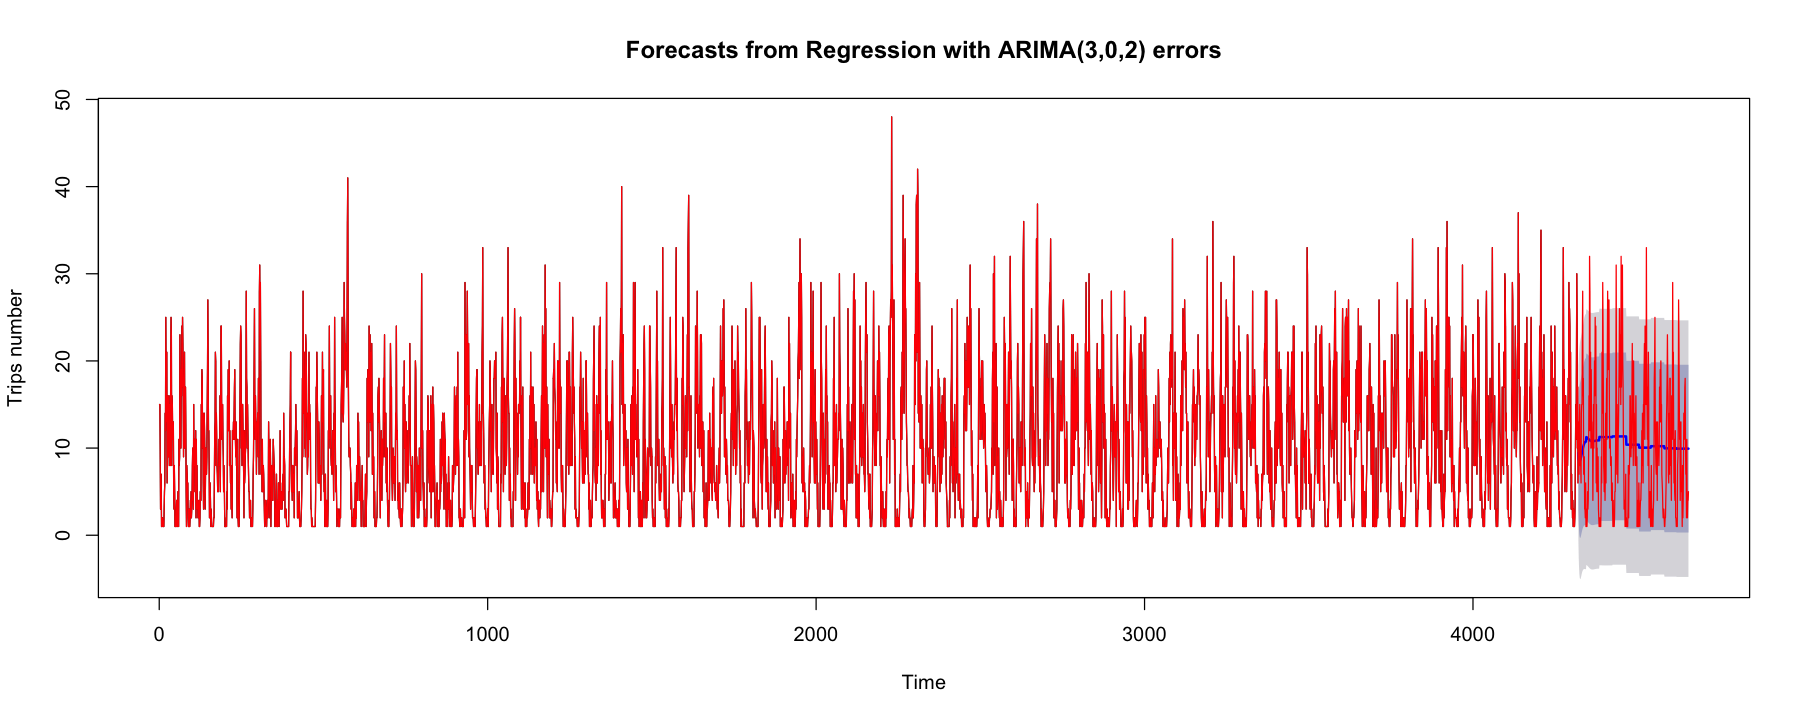

In [67]:
test_size <- nrow(test)
predicted <- forecast(model_exog,
                      xreg=data.matrix(test_exog_values),
                      h=test_size)

values = data.frame(predicted)$Point.Forecast

plot(predicted, ylab = xname, xlab = "Time")
lines(tSeries, col = "red")

In [68]:
MSE(values, testSeries)

[1] 54.23962

Как видно, теперь, auto.arima построила более сложную модель, подстроившись под погодные данные.

В данном случае, в отличие от модели с вручную подобранными параметрами, мы смогли улучшить незначительно улучшить качество, посредством добавления сторонних знаний о погодных условиях.